In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

2023-05-19 01:38:26.761719: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!pip install scalecast
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input, Dropout, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_tuner import RandomSearch

from matplotlib import pyplot as plt
from scalecast.Forecaster import Forecaster


[notice] A new release of pip available: 22.1.2 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [3]:
data = pd.read_csv("SECTIONNN.csv")

# Merge the date and time into one column
data['Timestamp'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])

# Set the index to the timestamp
data = data.set_index('Timestamp')

# Drop the date and time columns
data = data.drop(['Date', 'Time'], axis=1)

# Sort the data by timestamp
data = data.sort_index()

# Only timestamp and number of vehicles are needed
data = data[['No of Vehicles']]

# Check the data
data.head(30)

,No of Vehicles
Timestamp,
2022-10-01 00:00:00,4523
2022-10-01 01:00:00,3434
2022-10-01 02:00:00,2229
2022-10-01 03:00:00,1583
2022-10-01 04:00:00,1360
2022-10-01 05:00:00,1496
2022-10-01 06:00:00,1710
2022-10-01 07:00:00,2507
2022-10-01 08:00:00,3377


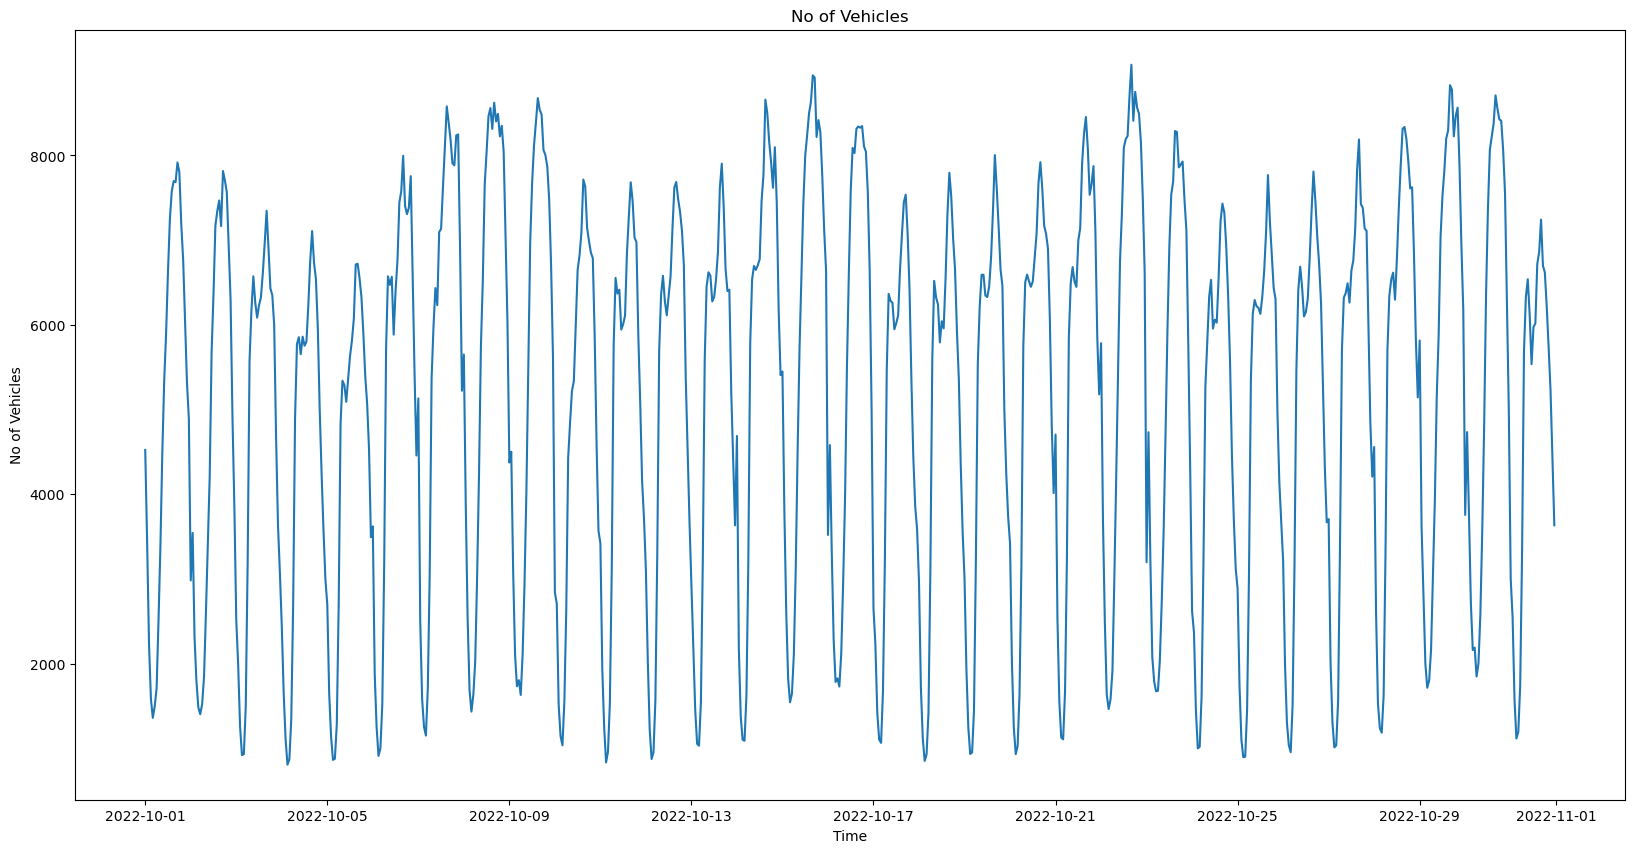

In [4]:
# Plot the data
plt.figure(figsize=(20, 10))
plt.plot(data['No of Vehicles'])
plt.title('No of Vehicles')
plt.xlabel('Time')
plt.ylabel('No of Vehicles')
plt.show()

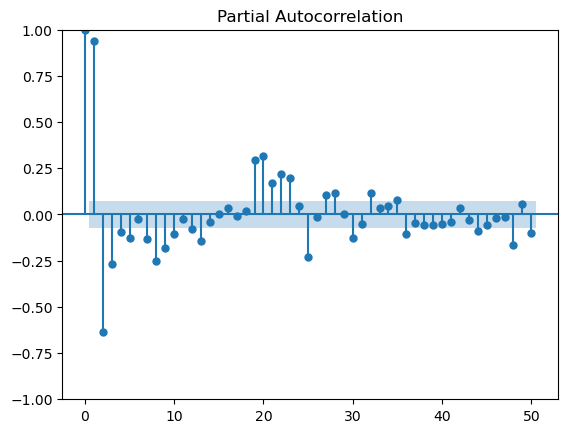

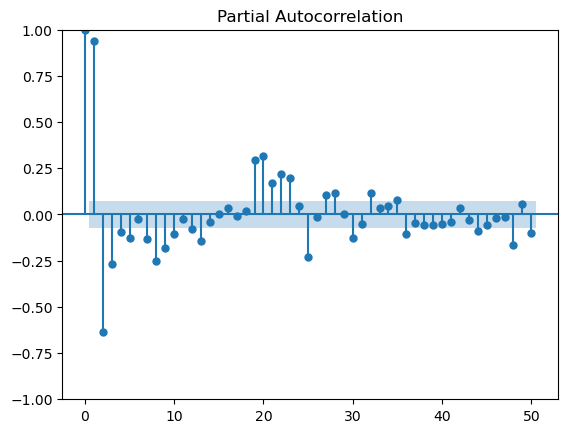

In [6]:
f = Forecaster(y=data['No of Vehicles'], current_dates=data.index)
f.plot_pacf(lags=50)

In [7]:
test_days = 10
data_per_day = 24

f.set_test_length(test_days * data_per_day)
f.generate_future_dates(5 * data_per_day)
f.set_estimator('lstm')

2023-05-19 01:43:28.105275: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 01:43:28.107170: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


20/20 [==============================] - 0s 832us/step


/mnt/A6E6E098E6E069CF/L4T2/Extra/ML/Notebook/env/lib/python3.10/site-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_default. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


<AxesSubplot: xlabel='Date', ylabel='Values'>

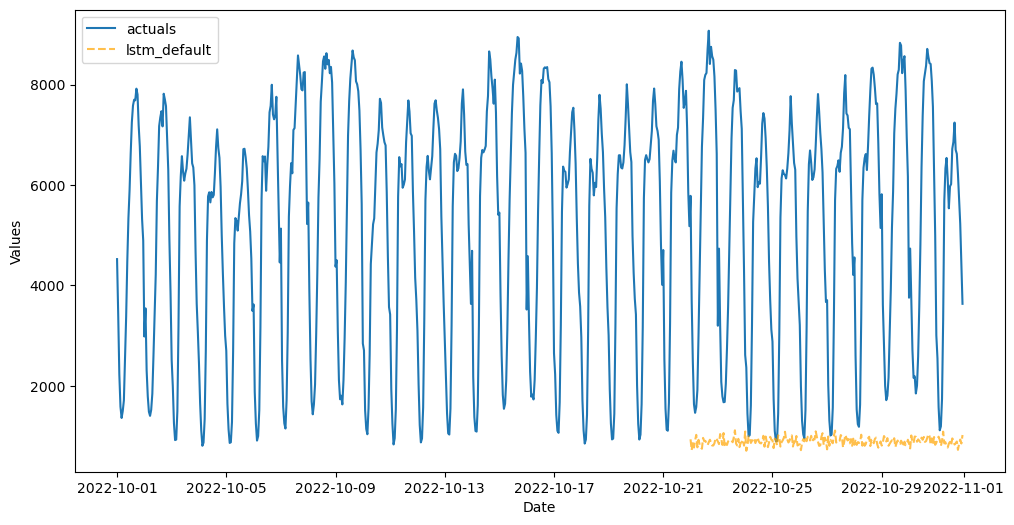

In [8]:
f.manual_forecast(call_me='lstm_default')
f.plot_test_set(ci=True)

19/19 [==============================] - 0s 2ms/step


/mnt/A6E6E098E6E069CF/L4T2/Extra/ML/Notebook/env/lib/python3.10/site-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_default. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/mnt/A6E6E098E6E069CF/L4T2/Extra/ML/Notebook/env/lib/python3.10/site-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_25lags. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


<AxesSubplot: xlabel='Date', ylabel='Values'>

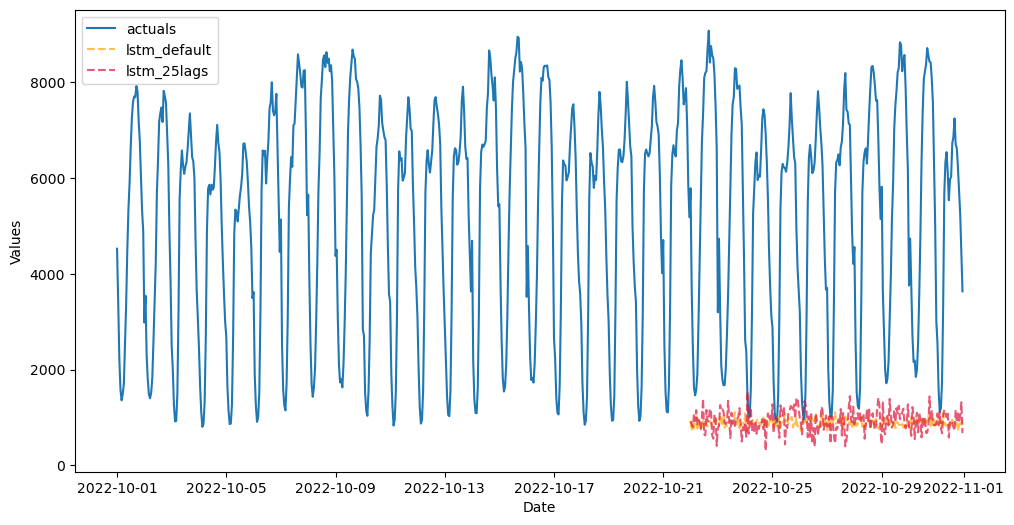

In [9]:
f.manual_forecast(call_me='lstm_25lags',lags=25)
f.plot_test_set(ci=True)

Epoch 1/5
7/7 [==============================] - 2s 111ms/step - loss: 0.5436 - val_loss: 0.5306
Epoch 2/5
7/7 [==============================] - 0s 48ms/step - loss: 0.5318 - val_loss: 0.5185
Epoch 3/5
7/7 [==============================] - 0s 41ms/step - loss: 0.5191 - val_loss: 0.5044
Epoch 4/5
7/7 [==============================] - 0s 51ms/step - loss: 0.5039 - val_loss: 0.4871
Epoch 5/5
1/1 [==============================] - 0s 282ms/step
Epoch 1/5
16/16 [==============================] - 3s 67ms/step - loss: 0.5267 - val_loss: 0.5058
Epoch 2/5
16/16 [==============================] - 0s 25ms/step - loss: 0.4961 - val_loss: 0.4690
Epoch 3/5
16/16 [==============================] - 0s 30ms/step - loss: 0.4510 - val_loss: 0.4091
Epoch 4/5
16/16 [==============================] - 1s 36ms/step - loss: 0.3808 - val_loss: 0.3274
Epoch 5/5
19/19 [==============================] - 0s 2ms/step


/mnt/A6E6E098E6E069CF/L4T2/Extra/ML/Notebook/env/lib/python3.10/site-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_default. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/mnt/A6E6E098E6E069CF/L4T2/Extra/ML/Notebook/env/lib/python3.10/site-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_25lags. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/mnt/A6E6E098E6E069CF/L4T2/Extra/ML/Notebook/env/lib/python3.10/site-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_20lags_5epochs. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


<AxesSubplot: xlabel='Date', ylabel='Values'>

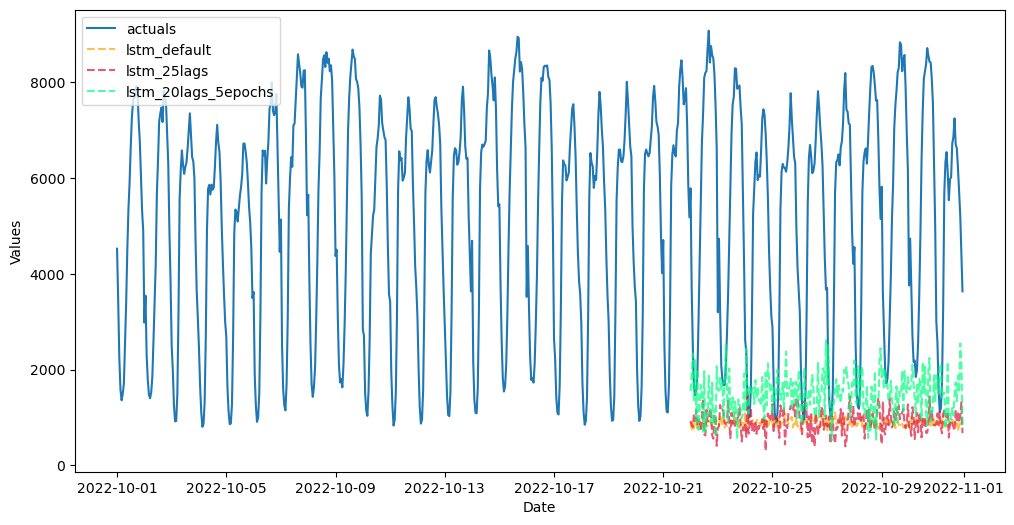

In [10]:
f.manual_forecast(call_me='lstm_20lags_5epochs',
                  lags=20,
                  epochs=5,
                  validation_split=.2,
                  shuffle=True)
f.plot_test_set(ci=True)

Epoch 1/25
7/7 [==============================] - 6s 324ms/step - loss: 0.5414 - val_loss: 0.5205
Epoch 2/25
7/7 [==============================] - 2s 259ms/step - loss: 0.5082 - val_loss: 0.4563
Epoch 3/25
7/7 [==============================] - 3s 329ms/step - loss: 0.4193 - val_loss: 0.3463
Epoch 4/25
7/7 [==============================] - 1s 184ms/step - loss: 0.3280 - val_loss: 0.2913
Epoch 5/25
7/7 [==============================] - 1s 116ms/step - loss: 0.2811 - val_loss: 0.2569
Epoch 6/25
7/7 [==============================] - 1s 104ms/step - loss: 0.2578 - val_loss: 0.2473
Epoch 7/25
7/7 [==============================] - 1s 94ms/step - loss: 0.2516 - val_loss: 0.2444
Epoch 8/25
7/7 [==============================] - 1s 92ms/step - loss: 0.2491 - val_loss: 0.2428
Epoch 9/25
7/7 [==============================] - 1s 142ms/step - loss: 0.2483 - val_loss: 0.2421
Epoch 10/25
7/7 [==============================] - 1s 110ms/step - loss: 0.2475 - val_loss: 0.2410
Epoch 11/25
7/7 [====

/mnt/A6E6E098E6E069CF/L4T2/Extra/ML/Notebook/env/lib/python3.10/site-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_default. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/mnt/A6E6E098E6E069CF/L4T2/Extra/ML/Notebook/env/lib/python3.10/site-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_25lags. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/mnt/A6E6E098E6E069CF/L4T2/Extra/ML/Notebook/env/lib/python3.10/site-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_20lags_5epochs. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/mnt/A6E6E098E6E069CF/L4T2/Extra/ML/Notebook/env/lib/python3.10/site-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_20lags_earlystop_3layers. To turn on confiden

<AxesSubplot: xlabel='Date', ylabel='Values'>

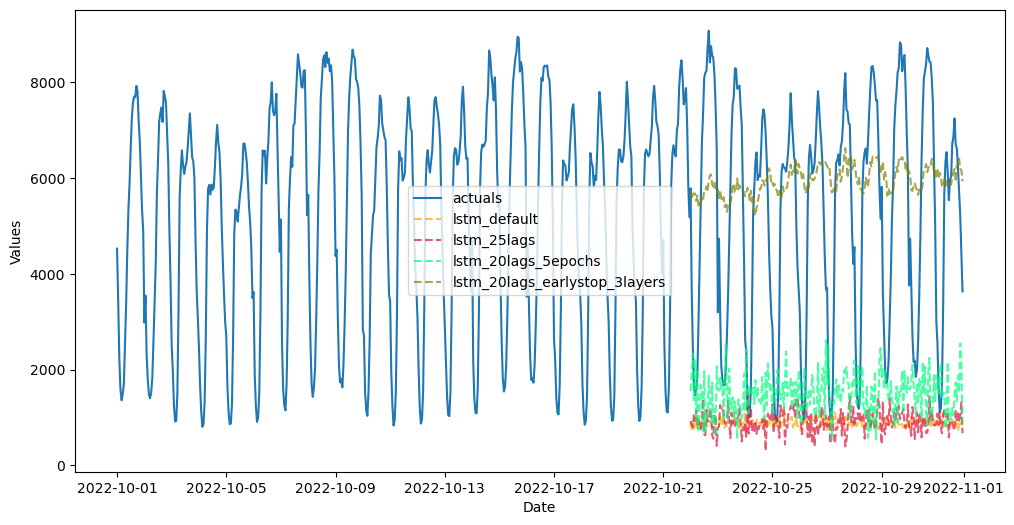

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

f.manual_forecast(call_me='lstm_20lags_earlystop_3layers',
                  lags=20,
                  epochs=25,
                  validation_split=.2,
                  shuffle=True,
                  callbacks=EarlyStopping(monitor='val_loss',
                                          patience=5),
                  lstm_layer_sizes=(32,32,32),
                  dropout=(0,0,0))
f.plot_test_set(ci=True)

INFO:tensorflow:Assets written to: ram://3eabbee9-89bb-400d-8585-1cbd67bb1377/assets
Epoch 1/15
6/6 [==============================] - 14s 864ms/step - loss: 0.5260 - val_loss: 0.4436
Epoch 2/15
6/6 [==============================] - 7s 1s/step - loss: 0.3983 - val_loss: 0.3281
Epoch 3/15
6/6 [==============================] - 8s 1s/step - loss: 0.3060 - val_loss: 0.2685
Epoch 4/15
6/6 [==============================] - 21s 4s/step - loss: 0.2649 - val_loss: 0.2499
Epoch 5/15
6/6 [==============================] - 6s 377ms/step - loss: 0.2530 - val_loss: 0.2459
Epoch 6/15
6/6 [==============================] - 14s 3s/step - loss: 0.2509 - val_loss: 0.2440
Epoch 7/15
6/6 [==============================] - 5s 638ms/step - loss: 0.2492 - val_loss: 0.2420
Epoch 8/15
6/6 [==============================] - 15s 3s/step - loss: 0.2472 - val_loss: 0.2408
Epoch 9/15
6/6 [==============================] - 19s 4s/step - loss: 0.2466 - val_loss: 0.2408
Epoch 10/15
6/6 [=============================

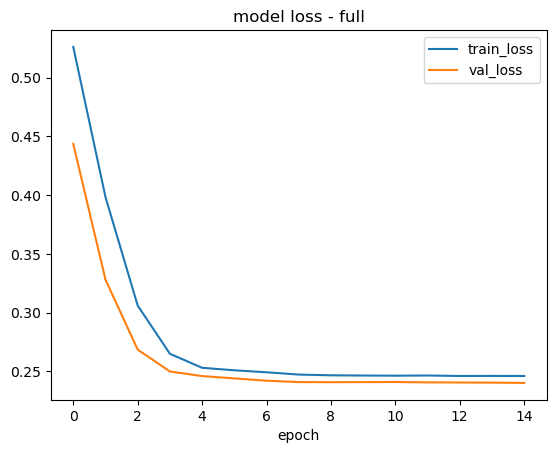

Epoch 1/15
15/15 [==============================] - 18s 743ms/step - loss: 0.4328 - val_loss: 0.2898
Epoch 2/15
15/15 [==============================] - 5s 332ms/step - loss: 0.2649 - val_loss: 0.2390
Epoch 3/15
15/15 [==============================] - 10s 657ms/step - loss: 0.2468 - val_loss: 0.2352
Epoch 4/15
15/15 [==============================] - 11s 775ms/step - loss: 0.2443 - val_loss: 0.2341
Epoch 5/15
15/15 [==============================] - 3s 226ms/step - loss: 0.2434 - val_loss: 0.2337
Epoch 6/15
15/15 [==============================] - 5s 331ms/step - loss: 0.2434 - val_loss: 0.2322
Epoch 7/15
15/15 [==============================] - 14s 944ms/step - loss: 0.2332 - val_loss: 0.2090
Epoch 8/15
15/15 [==============================] - 5s 298ms/step - loss: 0.1927 - val_loss: 0.1547
Epoch 9/15
15/15 [==============================] - 9s 599ms/step - loss: 0.1391 - val_loss: 0.1186
Epoch 10/15
15/15 [==============================] - 5s 362ms/step - loss: 0.1167 - val_loss: 0.

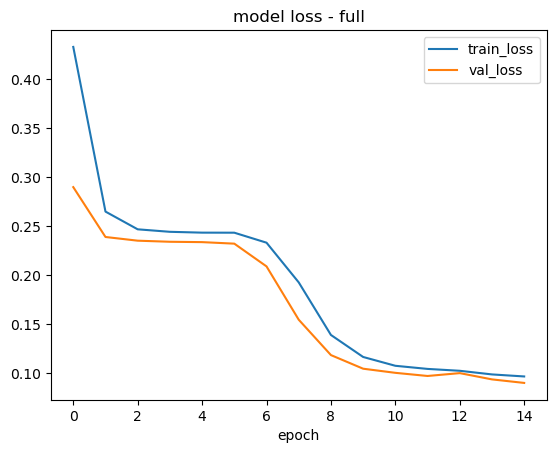

/mnt/A6E6E098E6E069CF/L4T2/Extra/ML/Notebook/env/lib/python3.10/site-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_default. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/mnt/A6E6E098E6E069CF/L4T2/Extra/ML/Notebook/env/lib/python3.10/site-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_25lags. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/mnt/A6E6E098E6E069CF/L4T2/Extra/ML/Notebook/env/lib/python3.10/site-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_20lags_5epochs. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/mnt/A6E6E098E6E069CF/L4T2/Extra/ML/Notebook/env/lib/python3.10/site-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_20lags_earlystop_3layers. To turn on confiden

<AxesSubplot: xlabel='Date', ylabel='Values'>

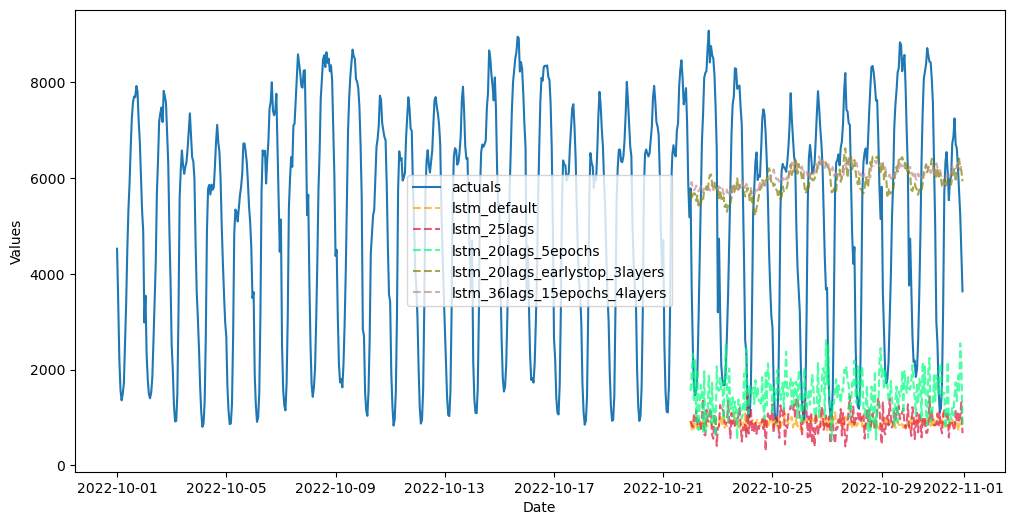

In [12]:
f.manual_forecast(call_me='lstm_36lags_15epochs_4layers',
                  lags=36,
                  batch_size=32,
                  epochs=15,
                  validation_split=.2,
                  shuffle=True,
                  activation='tanh',
                  optimizer='Adam',
                  learning_rate=0.001,
                  lstm_layer_sizes=(72,)*4,
                  dropout=(0,)*4,
                  plot_loss=True)
f.plot_test_set(ci=True)

INFO:tensorflow:Assets written to: ram://75b64321-2d4b-4049-82af-fe7137f057ee/assets
Epoch 1/15
6/6 [==============================] - 10s 634ms/step - loss: 0.5336 - val_loss: 0.4877
Epoch 2/15
6/6 [==============================] - 2s 288ms/step - loss: 0.4297 - val_loss: 0.3586
Epoch 3/15
6/6 [==============================] - 3s 643ms/step - loss: 0.3278 - val_loss: 0.2841
Epoch 4/15
6/6 [==============================] - 2s 315ms/step - loss: 0.2757 - val_loss: 0.2561
Epoch 5/15
6/6 [==============================] - 5s 880ms/step - loss: 0.2579 - val_loss: 0.2463
Epoch 6/15
6/6 [==============================] - 2s 249ms/step - loss: 0.2516 - val_loss: 0.2446
Epoch 7/15
6/6 [==============================] - 2s 344ms/step - loss: 0.2495 - val_loss: 0.2426
Epoch 8/15
6/6 [==============================] - 3s 468ms/step - loss: 0.2478 - val_loss: 0.2412
Epoch 9/15
6/6 [==============================] - 1s 218ms/step - loss: 0.2471 - val_loss: 0.2407
Epoch 10/15
6/6 [===============

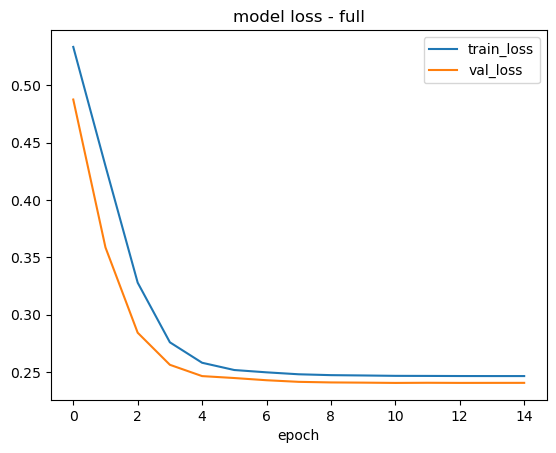

Epoch 1/15
15/15 [==============================] - 17s 537ms/step - loss: 0.4420 - val_loss: 0.3101
Epoch 2/15
15/15 [==============================] - 3s 217ms/step - loss: 0.2762 - val_loss: 0.2418
Epoch 3/15
15/15 [==============================] - 4s 268ms/step - loss: 0.2477 - val_loss: 0.2362
Epoch 4/15
15/15 [==============================] - 3s 210ms/step - loss: 0.2447 - val_loss: 0.2356
Epoch 5/15
15/15 [==============================] - 5s 318ms/step - loss: 0.2439 - val_loss: 0.2324
Epoch 6/15
15/15 [==============================] - 3s 219ms/step - loss: 0.2409 - val_loss: 0.2255
Epoch 7/15
15/15 [==============================] - 4s 259ms/step - loss: 0.2288 - val_loss: 0.2073
Epoch 8/15
15/15 [==============================] - 4s 250ms/step - loss: 0.2034 - val_loss: 0.1698
Epoch 9/15
15/15 [==============================] - 3s 212ms/step - loss: 0.1643 - val_loss: 0.1403
Epoch 10/15
15/15 [==============================] - 4s 260ms/step - loss: 0.1482 - val_loss: 0.123

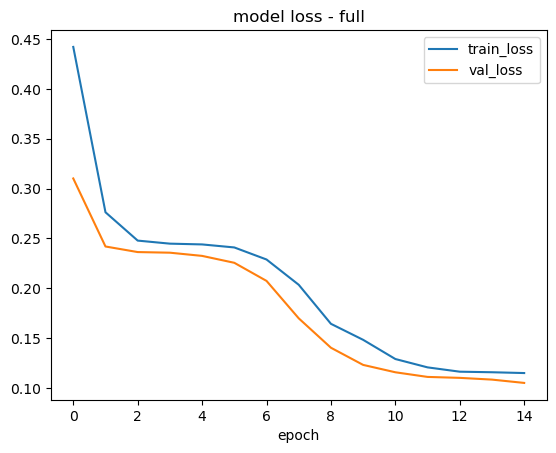

/mnt/A6E6E098E6E069CF/L4T2/Extra/ML/Notebook/env/lib/python3.10/site-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_default. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/mnt/A6E6E098E6E069CF/L4T2/Extra/ML/Notebook/env/lib/python3.10/site-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_25lags. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/mnt/A6E6E098E6E069CF/L4T2/Extra/ML/Notebook/env/lib/python3.10/site-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_20lags_5epochs. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/mnt/A6E6E098E6E069CF/L4T2/Extra/ML/Notebook/env/lib/python3.10/site-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_20lags_earlystop_3layers. To turn on confiden

<AxesSubplot: xlabel='Date', ylabel='Values'>

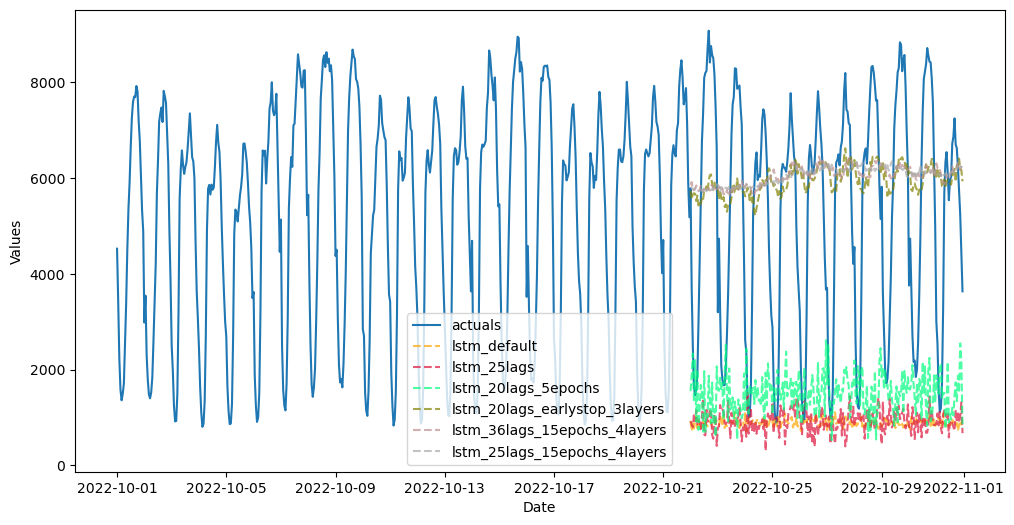

In [13]:
f.manual_forecast(call_me='lstm_25lags_15epochs_4layers',
                  lags=25,
                  batch_size=32,
                  epochs=15,
                  validation_split=.2,
                  shuffle=False,
                  activation='tanh',
                  optimizer='Adam',
                  learning_rate=0.001,
                  lstm_layer_sizes=(72,)*4,
                  dropout=(0,)*4,
                  plot_loss=True)
f.plot_test_set(ci=True)

In [14]:
f.export('model_summaries',determine_best_by='TestSetRMSE')[
    ['ModelNickname',
     'TestSetMAPE',
     'TestSetRMSE',
     'TestSetR2',
     'best_model']
]

,ModelNickname,TestSetMAPE,TestSetRMSE,TestSetR2,best_model
0,lstm_20lags_earlystop_3layers,0.791692,2379.009708,-0.000168,True
1,lstm_36lags_15epochs_4layers,0.825372,2485.680254,-0.091871,False
2,lstm_25lags_15epochs_4layers,0.829408,2501.373813,-0.105702,False
3,lstm_20lags_5epochs,0.649714,4533.247052,-2.631612,False
4,lstm_25lags,0.745236,4970.624863,-3.366191,False
5,lstm_default,0.752055,4993.751758,-3.406914,False


In [64]:
# Create the best model
# LSTM, lags=36, batch_size=32, epochs=15, activation='tanh', optimizer='Adam', learning_rate=0.001, lstm_layer_sizes=(72,)*4, dropout=(0,)*4
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

lag = 36

model = Sequential()
model.add(LSTM(72, input_shape=(lag, 1), return_sequences=True))
model.add(Dropout(0))
model.add(LSTM(72, return_sequences=True))
model.add(Dropout(0))
model.add(LSTM(72, return_sequences=True))
model.add(Dropout(0))
model.add(LSTM(72))
model.add(Dropout(0))
model.add(Dense(1, activation='tanh'))
model.compile(optimizer='Adam', loss='mean_squared_error')

model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 36, 72)            21312     
                                                                 
 dropout_20 (Dropout)        (None, 36, 72)            0         
                                                                 
 lstm_49 (LSTM)              (None, 36, 72)            41760     
                                                                 
 dropout_21 (Dropout)        (None, 36, 72)            0         
                                                                 
 lstm_50 (LSTM)              (None, 36, 72)            41760     
                                                                 
 dropout_22 (Dropout)        (None, 36, 72)            0         
                                                                 
 lstm_51 (LSTM)              (None, 72)              

In [65]:
# Train-test split
train = data['No of Vehicles'][:-test_days * data_per_day]
test = data['No of Vehicles'][-test_days * data_per_day:]

In [66]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train.values.reshape(-1, 1))
test = scaler.transform(test.values.reshape(-1, 1))

In [67]:
# Create the training data
X_train = []
y_train = []
for i in range(lag, len(train)):
    X_train.append(train[i-lag:i, 0])
    y_train.append(train[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [68]:
# Reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [69]:
# Train the model
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=.2, shuffle=True)

Epoch 1/15
12/12 [==============================] - 11s 462ms/step - loss: 0.1452 - val_loss: 0.0889
Epoch 2/15
12/12 [==============================] - 4s 347ms/step - loss: 0.0872 - val_loss: 0.0786
Epoch 3/15
12/12 [==============================] - 3s 214ms/step - loss: 0.0780 - val_loss: 0.0737
Epoch 4/15
12/12 [==============================] - 2s 199ms/step - loss: 0.0528 - val_loss: 0.0153
Epoch 5/15
12/12 [==============================] - 2s 205ms/step - loss: 0.0213 - val_loss: 0.0166
Epoch 6/15
12/12 [==============================] - 3s 236ms/step - loss: 0.0196 - val_loss: 0.0114
Epoch 7/15
12/12 [==============================] - 4s 305ms/step - loss: 0.0172 - val_loss: 0.0130
Epoch 8/15
12/12 [==============================] - 3s 229ms/step - loss: 0.0185 - val_loss: 0.0115
Epoch 9/15
12/12 [==============================] - 2s 198ms/step - loss: 0.0156 - val_loss: 0.0133
Epoch 10/15
12/12 [==============================] - 2s 196ms/step - loss: 0.0160 - val_loss: 0.009

In [70]:
# Create the test data
X_test = []
y_test = []
for i in range(lag, len(test)):
    X_test.append(test[i-lag:i, 0])
    y_test.append(test[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [71]:
# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [72]:
# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

7/7 [==============================] - 2s 97ms/step


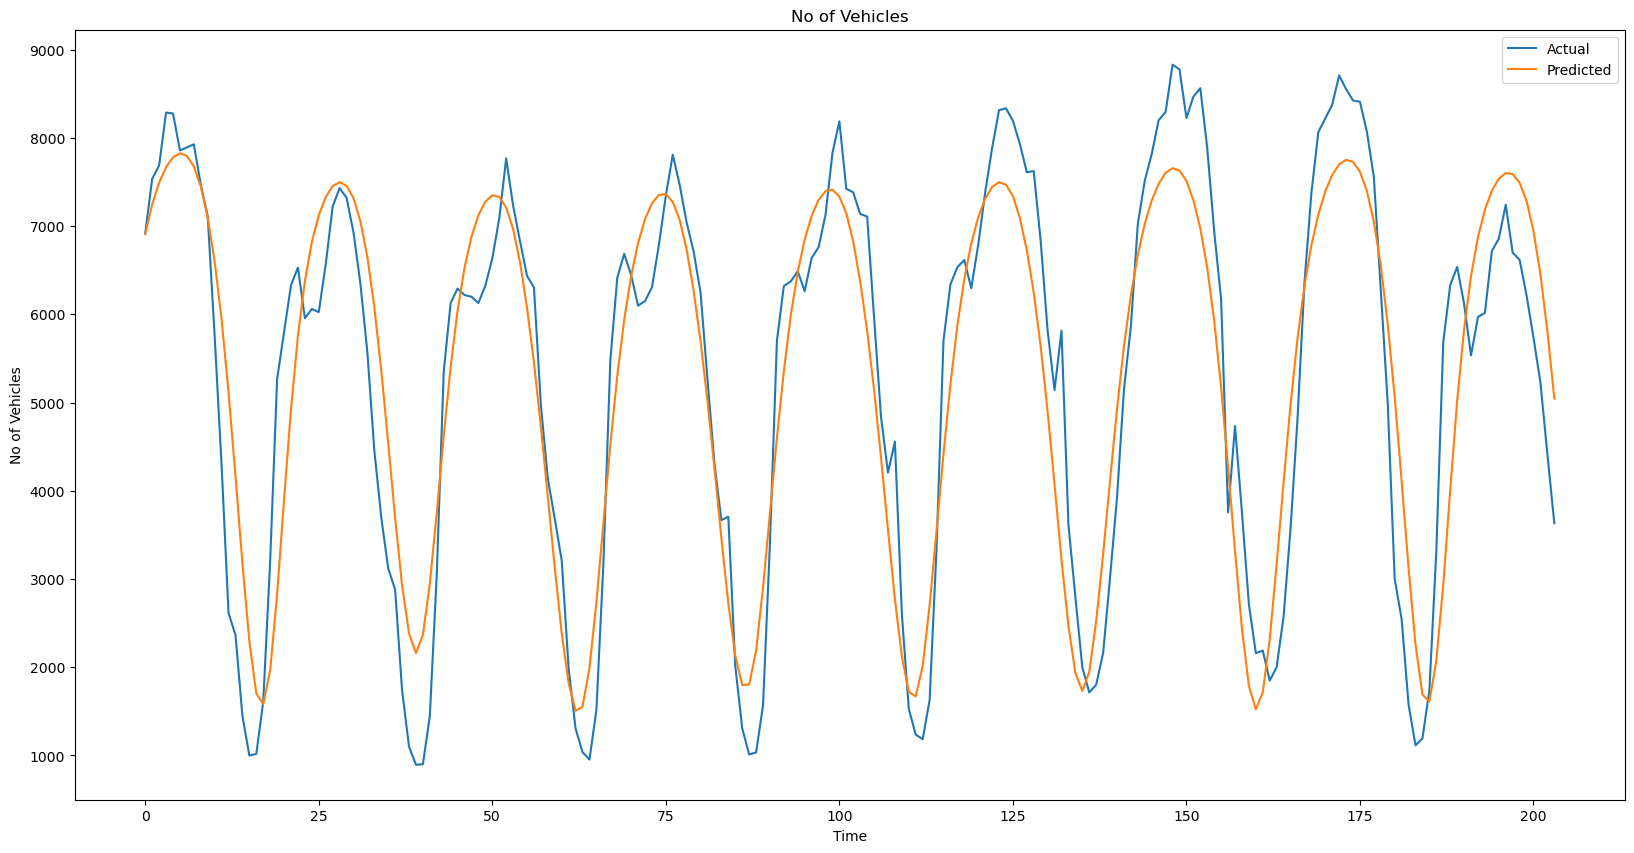

In [73]:
# np.array(predictions.reshape(-1)), np.array(data['Vehicles'][-test_days * data_per_day:])
# Plot the predictions
plt.figure(figsize=(20, 10))
plt.plot(np.array(data['No of Vehicles'][-test_days * data_per_day+lag:]), label='Actual')
plt.plot(np.array(predictions.reshape(-1)), label='Predicted')
plt.title('No of Vehicles')
plt.xlabel('Time')
plt.ylabel('No of Vehicles')
plt.legend()
plt.show()

In [74]:
# Calculate the error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mae = mean_absolute_error(np.array(data['No of Vehicles'][-test_days * data_per_day+lag:]), np.array(predictions.reshape(-1)))
mse = mean_squared_error(np.array(data['No of Vehicles'][-test_days * data_per_day+lag:]), np.array(predictions.reshape(-1)))
rmse = np.sqrt(mse)
r2 = r2_score(np.array(data['No of Vehicles'][-test_days * data_per_day+lag:]), np.array(predictions.reshape(-1)))

print('MAE: ', mae)
print('MSE: ', mse)
print('RMSE: ', rmse)
print('R2: ', r2)

MAE:  805.5394921396293
MSE:  924390.0193313173
RMSE:  961.4520369375257
R2:  0.8276757710751792


In [75]:
# Save the model
model.save('lstm_822r2_' + str(lag) + '.h5')